<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#First-Question:-Does-discount-amount-have-a-statistically-significant-effect-on-the-quantity-of-a-product-in-an-order?-If-so,-at-what-level(s)-of-discount?" data-toc-modified-id="First-Question:-Does-discount-amount-have-a-statistically-significant-effect-on-the-quantity-of-a-product-in-an-order?-If-so,-at-what-level(s)-of-discount?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>First Question: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?</a></span><ul class="toc-item"><li><span><a href="#Hypotheses:" data-toc-modified-id="Hypotheses:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Hypotheses:</a></span></li><li><span><a href="#Explore-Data" data-toc-modified-id="Explore-Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Explore Data</a></span><ul class="toc-item"><li><span><a href="#Observations-of-Discount" data-toc-modified-id="Observations-of-Discount-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Observations of Discount</a></span></li><li><span><a href="#Observations-of-Quantity-(The-dependant-variable)" data-toc-modified-id="Observations-of-Quantity-(The-dependant-variable)-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Observations of Quantity (The dependant variable)</a></span></li></ul></li><li><span><a href="#Run-Anova-Test" data-toc-modified-id="Run-Anova-Test-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Run Anova Test</a></span><ul class="toc-item"><li><span><a href="#The-Null-Hypothesis-is-Rejected" data-toc-modified-id="The-Null-Hypothesis-is-Rejected-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>The Null Hypothesis is Rejected</a></span></li></ul></li><li><span><a href="#Find-the-Effect-Size-of-Discount" data-toc-modified-id="Find-the-Effect-Size-of-Discount-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Find the Effect Size of Discount</a></span><ul class="toc-item"><li><span><a href="#Observations" data-toc-modified-id="Observations-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Observations</a></span></li><li><span><a href="#Observations:" data-toc-modified-id="Observations:-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Observations:</a></span></li></ul></li><li><span><a href="#Test-Each-Discount-Level-against-the-Control" data-toc-modified-id="Test-Each-Discount-Level-against-the-Control-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Test Each Discount Level against the Control</a></span><ul class="toc-item"><li><span><a href="#Observations:" data-toc-modified-id="Observations:-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Observations:</a></span></li><li><span><a href="#Find-effect-size-and-power-of-each-level" data-toc-modified-id="Find-effect-size-and-power-of-each-level-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Find effect size and power of each level</a></span><ul class="toc-item"><li><span><a href="#Discount-of-5%" data-toc-modified-id="Discount-of-5%-3.5.2.1"><span class="toc-item-num">3.5.2.1&nbsp;&nbsp;</span>Discount of 5%</a></span></li><li><span><a href="#Discount-of-10%" data-toc-modified-id="Discount-of-10%-3.5.2.2"><span class="toc-item-num">3.5.2.2&nbsp;&nbsp;</span>Discount of 10%</a></span></li><li><span><a href="#Discount-of-15%" data-toc-modified-id="Discount-of-15%-3.5.2.3"><span class="toc-item-num">3.5.2.3&nbsp;&nbsp;</span>Discount of 15%</a></span></li><li><span><a href="#Discount-20%" data-toc-modified-id="Discount-20%-3.5.2.4"><span class="toc-item-num">3.5.2.4&nbsp;&nbsp;</span>Discount 20%</a></span></li><li><span><a href="#Discount-of-25%" data-toc-modified-id="Discount-of-25%-3.5.2.5"><span class="toc-item-num">3.5.2.5&nbsp;&nbsp;</span>Discount of 25%</a></span></li></ul></li></ul></li><li><span><a href="#Business-Analysis" data-toc-modified-id="Business-Analysis-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Business Analysis</a></span></li></ul></li><li><span><a href="#Second-Question:-Do-US-employees-sell-significantly-more-than-UK-employees-per-order?" data-toc-modified-id="Second-Question:-Do-US-employees-sell-significantly-more-than-UK-employees-per-order?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Second Question: Do US employees sell significantly more than UK employees per order?</a></span><ul class="toc-item"><li><span><a href="#Hypotheses:" data-toc-modified-id="Hypotheses:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Hypotheses:</a></span></li><li><span><a href="#Explore-the-data" data-toc-modified-id="Explore-the-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Explore the data</a></span><ul class="toc-item"><li><span><a href="#Observations:" data-toc-modified-id="Observations:-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Observations:</a></span></li></ul></li><li><span><a href="#Run-ANOVA-test" data-toc-modified-id="Run-ANOVA-test-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Run ANOVA test</a></span></li><li><span><a href="#Results:-The-Null-Hypothesis-is-NOT-rejected." data-toc-modified-id="Results:-The-Null-Hypothesis-is-NOT-rejected.-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Results: The Null Hypothesis is NOT rejected.</a></span></li><li><span><a href="#Get-rid-of-outliers-and-run-ANOVA-test-again-just-to-be-sure" data-toc-modified-id="Get-rid-of-outliers-and-run-ANOVA-test-again-just-to-be-sure-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Get rid of outliers and run ANOVA test again just to be sure</a></span><ul class="toc-item"><li><span><a href="#Observations:" data-toc-modified-id="Observations:-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>Observations:</a></span></li></ul></li><li><span><a href="#Plot-Each-Country-Against-itself" data-toc-modified-id="Plot-Each-Country-Against-itself-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Plot Each Country Against itself</a></span><ul class="toc-item"><li><span><a href="#Observations:" data-toc-modified-id="Observations:-4.6.1"><span class="toc-item-num">4.6.1&nbsp;&nbsp;</span>Observations:</a></span></li></ul></li><li><span><a href="#Business-Analysis" data-toc-modified-id="Business-Analysis-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Business Analysis</a></span></li></ul></li><li><span><a href="#Third-Question:-Does-an-employee's-age-have-a-statistically-significant-effect-on-order-totals?" data-toc-modified-id="Third-Question:-Does-an-employee's-age-have-a-statistically-significant-effect-on-order-totals?-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Third Question: Does an employee's age have a statistically significant effect on order totals?</a></span><ul class="toc-item"><li><span><a href="#Hypotheses:" data-toc-modified-id="Hypotheses:-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Hypotheses:</a></span></li><li><span><a href="#Explore-data" data-toc-modified-id="Explore-data-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Explore data</a></span></li><li><span><a href="#Observations:" data-toc-modified-id="Observations:-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Observations:</a></span></li><li><span><a href="#Remove-outliers-and-run-anova-again" data-toc-modified-id="Remove-outliers-and-run-anova-again-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Remove outliers and run anova again</a></span><ul class="toc-item"><li><span><a href="#Observations:" data-toc-modified-id="Observations:-5.4.1"><span class="toc-item-num">5.4.1&nbsp;&nbsp;</span>Observations:</a></span></li></ul></li><li><span><a href="#Business-Analysis:" data-toc-modified-id="Business-Analysis:-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Business Analysis:</a></span></li></ul></li><li><span><a href="#Fourth-Question:-Do-countries-shipped-to-have-a-statistically-significant-effect-on-discounts?" data-toc-modified-id="Fourth-Question:-Do-countries-shipped-to-have-a-statistically-significant-effect-on-discounts?-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Fourth Question: Do countries shipped to have a statistically significant effect on discounts?</a></span><ul class="toc-item"><li><span><a href="#Hypotheses:" data-toc-modified-id="Hypotheses:-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Hypotheses:</a></span></li><li><span><a href="#Explore-Data" data-toc-modified-id="Explore-Data-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Explore Data</a></span></li><li><span><a href="#Run-ANOVA-to-see-if-there-is-any-significance-between-Country-and-TotalSales" data-toc-modified-id="Run-ANOVA-to-see-if-there-is-any-significance-between-Country-and-TotalSales-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Run ANOVA to see if there is any significance between Country and TotalSales</a></span><ul class="toc-item"><li><span><a href="#Null-Hypothesis-is-rejected" data-toc-modified-id="Null-Hypothesis-is-rejected-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Null Hypothesis is rejected</a></span></li></ul></li><li><span><a href="#Further-analysis-to-see-if-any-countries-stand-out." data-toc-modified-id="Further-analysis-to-see-if-any-countries-stand-out.-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Further analysis to see if any countries stand out.</a></span><ul class="toc-item"><li><span><a href="#Observations:" data-toc-modified-id="Observations:-6.4.1"><span class="toc-item-num">6.4.1&nbsp;&nbsp;</span>Observations:</a></span></li><li><span><a href="#Observations:" data-toc-modified-id="Observations:-6.4.2"><span class="toc-item-num">6.4.2&nbsp;&nbsp;</span>Observations:</a></span></li></ul></li><li><span><a href="#Business-Analysis:" data-toc-modified-id="Business-Analysis:-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Business Analysis:</a></span></li></ul></li></ul></div>

# Import Libraries

In [1]:
#import libraries and functions
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
%matplotlib inline

In [2]:
#get sql database
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
#Show names of all the tables
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


# Functions

In [4]:
def query_to_df(query):
    """Takes in a SQL query and returns a pandas dataframe with column names"""
    
    cur.execute(query)
    df = pd.DataFrame(cur.fetchall())
    df.columns = [x[0] for x in cur.description]
    return df

In [5]:
def find_s(a, b):
    """a and b are arrays from the control and experimental group
       used to find the s in the denominator of cohen's d equatin to find effect size"""
    
    num = (len(a)-1)*(a.std())**2 + (len(b)-1)*(b.std())**2
    denom = len(a) + len(b)
    return np.sqrt(num/denom)

In [6]:
def get_sample_size(alpha, power, a, b):
    """ Calculate what sample size is needed for Control and Experimental"""
    
    power_analysis = TTestIndPower()
    alpha = 0.05
    power = 0.80
    mean_difference = abs(a.mean()-b.mean())
    s = find_s(a, b)
    effect_size = mean_difference / s
    sample_size = power_analysis.solve_power(alpha=.05, effect_size=effect_size, power=.80, alternative='larger')
    print("""Using alpha = {}, effect size = {}, and power = {}: 
             The sample size should be {}""".format(alpha, effect_size, power, sample_size))
    return int(np.round(sample_size) + 1)

In [7]:
def cohend(d1, d2):
    """function to calculate Cohen's d for two independent samples"""
    
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = d1.var(), d2.var()
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = d1.mean(), d2.mean()
    # calculate the effect size
    return (u1 - u2) / s

In [8]:
def effect_size_and_power(df, disc, name):
    """Pass in a dataframe with dummy variables and the discount amount you want
       To compare to the control"""
    
    no_disc = df.loc[df.Disc_0 == 1]
    yes_disc = df.loc[df[disc] == 1]
    mean_diff = yes_disc.Quantity.mean()-no_disc.Quantity.mean()
    print('For ', name)
    print('mean difference:', mean_diff)
    
    effect_size = cohend(yes_disc.Quantity, no_disc.Quantity)
    print('effect size:', effect_size)
    
    power1 = statsmodels.stats.power.tt_ind_solve_power(effect_size=effect_size, 
                                                       alpha=.05, nobs1=len(yes_disc))
    power2 = statsmodels.stats.power.tt_ind_solve_power(effect_size=effect_size, 
                                                       alpha=.05, nobs1=len(no_disc))
    
    #Average powers with length of each sample since they are uneven
    power = (power1+power2)/2
    print('power:', power)
    
    plt.figure(figsize=(10,8))
    sns.distplot(yes_disc.Quantity, label=name);
    sns.distplot(no_disc.Quantity, label='No Discount');
    plt.legend();
    
    return [mean_diff, effect_size]

# First Question: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

## Hypotheses:
Null: There is no significant effect from discount on quantity of a product in an order

Alternative: There is a signifiant effect from discount on quantity of a product in an order

## Explore Data

In [9]:
#query 1
#Need Discount & Quantity from OrderDetail table
query1 = """SELECT Discount, Quantity
            FROM OrderDetail;"""
df1 = query_to_df(query1)

In [10]:
df1.head()

,Discount,Quantity
0,0.0,12
1,0.0,10
2,0.0,5
3,0.0,9
4,0.0,40


In [11]:
df1.describe()

,Discount,Quantity
count,2155.000000,2155.000000
mean,0.056167,23.812993
std,0.083450,19.022047
min,0.000000,1.000000
25%,0.000000,10.000000
50%,0.000000,20.000000
75%,0.100000,30.000000
max,0.250000,130.000000


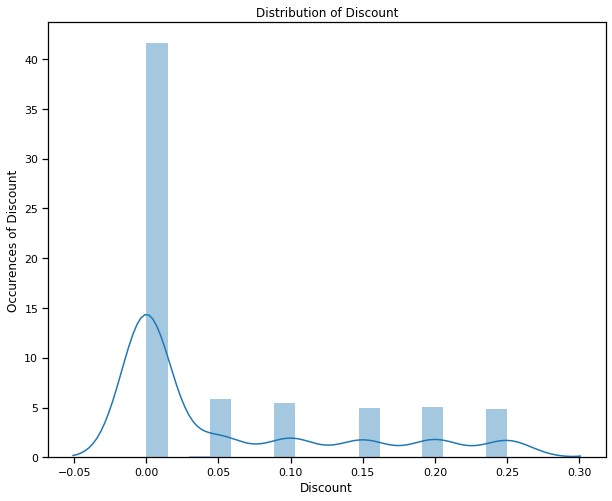

In [12]:
#distribution of Discount
plt.figure(figsize=(10,8))
sns.set_context('notebook')

sns.distplot(df1.Discount);
plt.title('Distribution of Discount');
plt.ylabel('Occurences of Discount');


### Observations of Discount
- Discount is an ordinal variable
- Most orders have a 0% discount
- Has a very long right tail

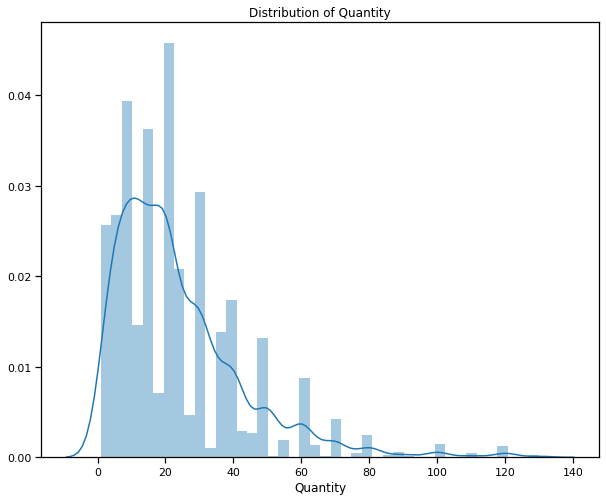

In [13]:
#Discount of Quantity
plt.figure(figsize=(10,8))
sns.distplot(df1.Quantity);
plt.title('Distribution of Quantity');

### Observations of Quantity (The dependant variable)
- Positively skewed
- Minimum value is 1, max value is 130
- The mean is around 20

## Run Anova Test
The one-way analysis of variance (ANOVA) is used to determine whether there are any statistically significant differences between the means of two or more independent (unrelated) groups.
For an ANOVA Test, any categorical variable has to be broken down into dummy varaibles. For this ANOVA test it will compare Quantity to whether or not there was a discount. So I will create a new column that has a '1' for discount present, and '2' for no discount

In [14]:
df1['Discount_Present'] = 1
df1.loc[df1.Discount == 0, 'Discount_Present'] = 0

In [15]:
df1.Discount_Present.value_counts()

0    1317
1     838
Name: Discount_Present, dtype: int64

In [16]:
#run anova test
formula = 'Quantity ~ C(Discount_Present)'
lm = ols(formula, df1).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                            sum_sq      df          F        PR(>F)
C(Discount_Present)   14903.513199     1.0  41.971781  1.144092e-10
Residual             764496.122996  2153.0        NaN           NaN


### The Null Hypothesis is Rejected
The p-value is way below 0.05, it is 1.144092e-10. This means that further analysis is needed to discover which levels have the highest effect. 

## Find the Effect Size of Discount

In [17]:
#make control group, discount = 0
control = df1[df1['Discount']==0]
control.describe()

,Discount,Quantity,Discount_Present
count,1317.0,1317.000000,1317.0
mean,0.0,21.715262,0.0
std,0.0,17.507493,0.0
min,0.0,1.000000,0.0
25%,0.0,10.000000,0.0
50%,0.0,18.000000,0.0
75%,0.0,30.000000,0.0
max,0.0,130.000000,0.0


In [18]:
#make experimental group, discount != 0
experimental = df1[df1['Discount']!=0]
experimental.describe()

,Discount,Quantity,Discount_Present
count,838.000000,838.000000,838.0
mean,0.144439,27.109785,1.0
std,0.071808,20.771439,0.0
min,0.010000,1.000000,1.0
25%,0.100000,12.000000,1.0
50%,0.150000,20.000000,1.0
75%,0.200000,36.000000,1.0
max,0.250000,130.000000,1.0


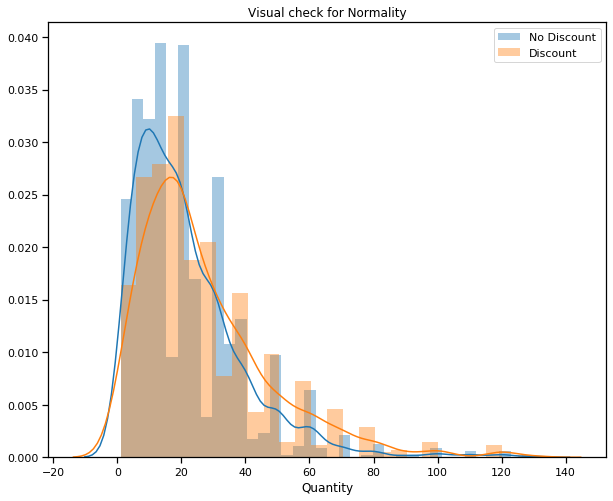

In [19]:
#Plot Control and Experimental to check for Normality
plt.figure(figsize=(10,8))
sns.distplot(control.Quantity, label='No Discount');
sns.distplot(experimental.Quantity, label='Discount');
plt.title('Visual check for Normality');
plt.legend();

### Observations
1. Positively skewed
2. A lot of overlap
3. There a a couple of outliers that I will remove. I will only include values in the 95% Quantile

In [20]:
control = control.loc[control.Quantity <= control.Quantity.quantile(.95)]
experimental = experimental.loc[experimental.Quantity <= experimental.Quantity.quantile(.95)]

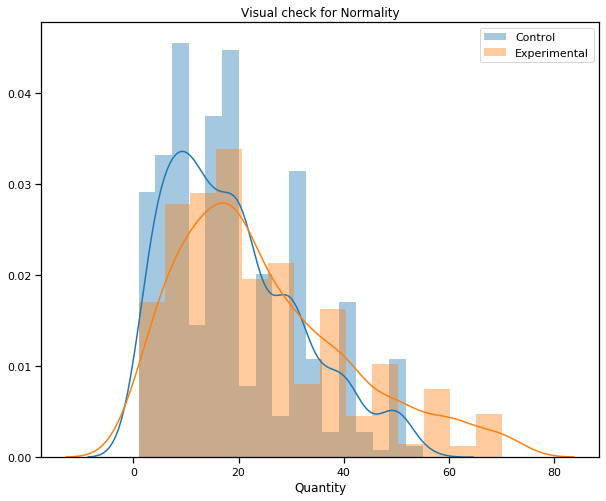

In [21]:
plt.figure(figsize=(10,8))
sns.distplot(control.Quantity, label='Control');
sns.distplot(experimental.Quantity, label='Experimental');
plt.title('Visual check for Normality');
plt.legend();

In [22]:
#Find difference of means between no-discount and discount
mean_diff = experimental.Quantity.mean()-control.Quantity.mean()
print(mean_diff)

5.685784327276604


In [23]:
#Find Cohen's D
d = cohend(experimental.Quantity, control.Quantity)
print(d)

0.3996959562139606


In [24]:
#Take power with each number of observations per group and then average since they are different sizes
power1 = statsmodels.stats.power.tt_ind_solve_power(effect_size=d, alpha=.05, nobs1=len(experimental))
power2 = statsmodels.stats.power.tt_ind_solve_power(effect_size=d, alpha=.05, nobs1=len(control))
power = (power1+power2)/2
print(power)

1.0


### Observations: 
Cohen's d is an appropriate effect size for the comparison between two means. A value of roughly 0.4 is considered a a small to medium effect. Now the effect size of each individual discount needs to be calculated. I ran the power test as a baseline for future power tests for each individual discounts

## Test Each Discount Level against the Control
First make dummy variables for each level of discount to with ANOVA to see if all discounts reject the Null Hypothesis
Then Find the effect size and Power of each individual Discount Level.


In [25]:
df1.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Discounts of 1%, 2%, 3%, 4% and 6% all have 3 or less occurences. I will just drop them since they are such unusual occurences

In [26]:
df1.drop(df1.loc[df1['Discount']==0.01].index, inplace=True)
df1.drop(df1.loc[df1['Discount']==0.02].index, inplace=True)
df1.drop(df1.loc[df1['Discount']==0.03].index, inplace=True)
df1.drop(df1.loc[df1['Discount']==0.04].index, inplace=True)
df1.drop(df1.loc[df1['Discount']==0.06].index, inplace=True)

In [27]:
df1 = df1.loc[df1.Quantity <= control.Quantity.quantile(.95)]

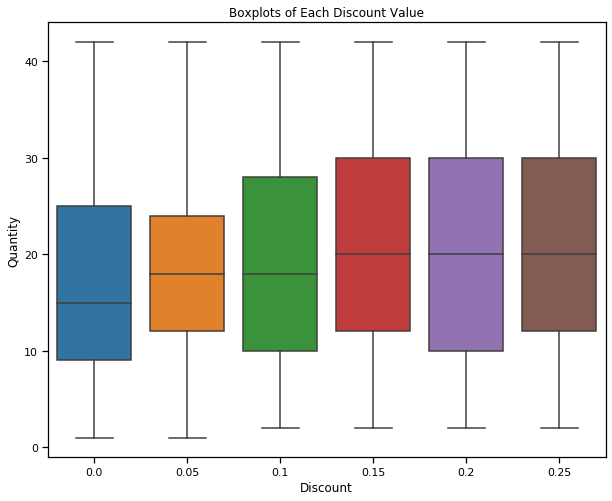

In [28]:
plt.figure(figsize=(10,8))
sns.boxplot(df1.Discount, df1.Quantity);
plt.title('Boxplots of Each Discount Value');

In [29]:
#get dummy variables for discount levels
disc_dummies = pd.get_dummies(df1.Discount, prefix='Disc')

In [30]:
df1 = pd.concat([df1, disc_dummies], axis=1)
df1.head()

,Discount,Quantity,Discount_Present,Disc_0.0,Disc_0.05,Disc_0.1,Disc_0.15,Disc_0.2,Disc_0.25
0,0.0,12,0,1,0,0,0,0,0
1,0.0,10,0,1,0,0,0,0,0
2,0.0,5,0,1,0,0,0,0,0
3,0.0,9,0,1,0,0,0,0,0
4,0.0,40,0,1,0,0,0,0,0


In [31]:
df1.sum()

Discount              100.9
Quantity            34626.0
Discount_Present      693.0
Disc_0.0             1190.0
Disc_0.05             149.0
Disc_0.1              153.0
Disc_0.15             130.0
Disc_0.2              132.0
Disc_0.25             129.0
dtype: float64

In [32]:
#Rename columns so they will work in ANOVA
df1.rename(columns={'Disc_0.0': 'Disc_0', 'Disc_0.05': 'Disc_05', 
                    'Disc_0.1': 'Disc_1', 'Disc_0.15': 'Disc_15', 
                    'Disc_0.2': 'Disc_2', 'Disc_0.25': 'Disc_25'},  
           inplace=True)

In [33]:
formula = 'Quantity ~ C(Disc_0) + C(Disc_05) + C(Disc_1) + C(Disc_15) + C(Disc_2) + C(Disc_25)'
lm = ols(formula, df1).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                   sum_sq      df          F        PR(>F)
C(Disc_0)      297.413627     1.0   2.553414  1.102245e-01
C(Disc_05)     696.297635     1.0   5.977992  1.457685e-02
C(Disc_1)     1087.539573     1.0   9.336960  2.277406e-03
C(Disc_15)    2258.615310     1.0  19.391111  1.124991e-05
C(Disc_2)     1874.559822     1.0  16.093842  6.264468e-05
C(Disc_25)    3406.305784     1.0  29.244491  7.195771e-08
Residual    218627.021226  1877.0        NaN           NaN


### Observations:
All discount levels reject the Null Hypothesis

### Find effect size and power of each level

#### Discount of 5%

For  5% Discount
mean difference: 1.3306130505893634
effect size: 0.12525350174851452
power: 0.5265095594926592


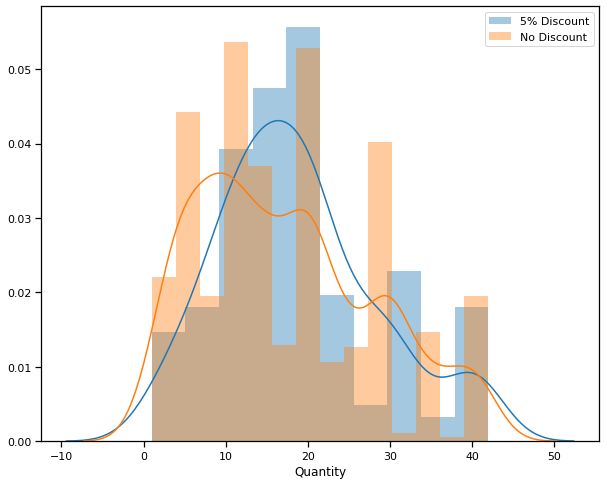

In [34]:
disc05 = effect_size_and_power(df1, 'Disc_05', '5% Discount')

#### Discount of 10%

For  10% Discount
mean difference: 1.7937441643323986
effect size: 0.16675864098169604
power: 0.6445698212677156


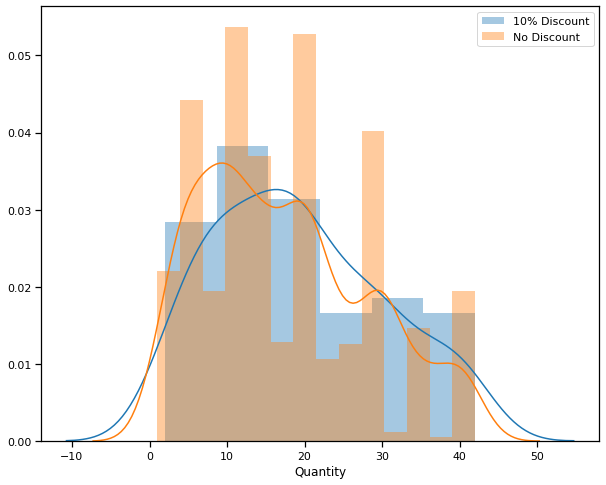

In [35]:
disc10 = effect_size_and_power(df1, 'Disc_1', '10% Discount')

#### Discount of 15%

For  15% Discount
mean difference: 3.1223012281835807
effect size: 0.2901748841773919
power: 0.8223050966629614


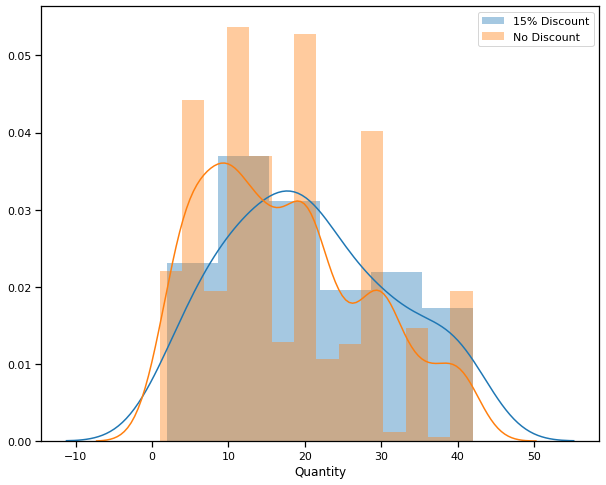

In [36]:
disc15 = effect_size_and_power(df1, 'Disc_15', '15% Discount')

#### Discount 20%

For  20% Discount
mean difference: 2.765075120957473
effect size: 0.2558934782286478
power: 0.7721693798176957


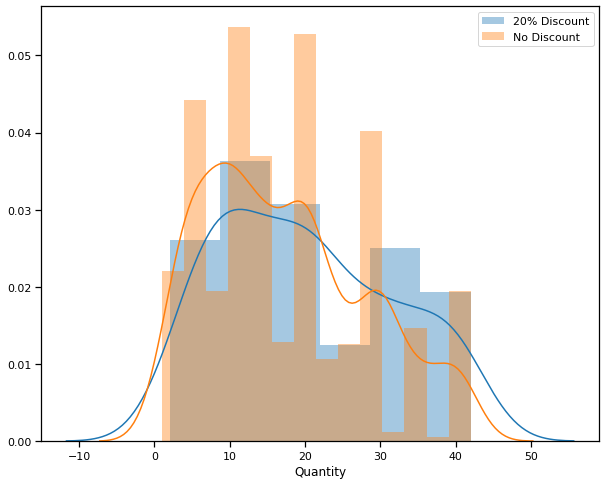

In [37]:
disc20 = effect_size_and_power(df1, 'Disc_2', '20% Discount')

#### Discount of 25%

For  25% Discount
mean difference: 3.99499055436128
effect size: 0.369855864122462
power: 0.9205826858892074


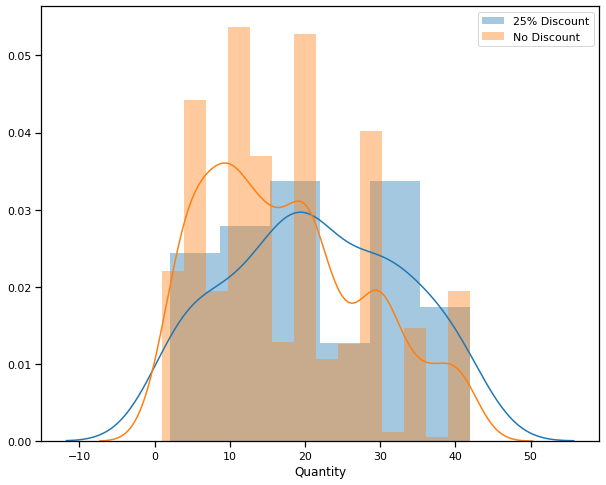

In [38]:
disc25 = effect_size_and_power(df1, 'Disc_25', '25% Discount')

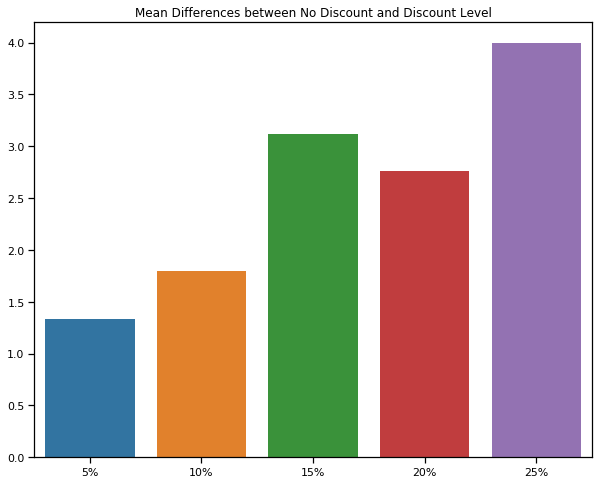

In [39]:
#Plot all mean differences
means = [disc05[0], disc10[0], disc15[0], disc20[0], disc25[0]]
x = ['5%', '10%', '15%', '20%', '25%']
plt.figure(figsize=(10,8))
sns.barplot(x, means)
plt.title('Mean Differences between No Discount and Discount Level');

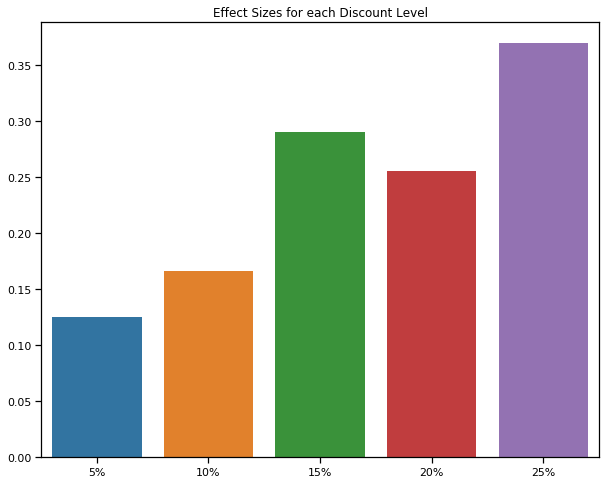

In [40]:
#Plot all Effect Sizes
effect_sizes = [disc05[1], disc10[1], disc15[1], disc20[1], disc25[1]]
x = ['5%', '10%', '15%', '20%', '25%']
plt.figure(figsize=(10,8))
sns.barplot(x, effect_sizes)
plt.title('Effect Sizes for each Discount Level');

25% and 15% have the largest effect on quantities sold. 

## Business Analysis
When discounts are above either 15% or 25% there is a noticeable effect on the quantity of products sold. The effect size for these is around 0.29 for 15% and 0.37 for 25% which indicates a small effect according to Cohen. Using these larger discounts could help push products that maybe need to get sold to make room for other products or to make space in warehouses. It makes sense that a higher discount would mean more products are sold. However further analysis would be needed to see if the discounts are affecting revenue in any way. Such as do these discounts pay for themselves or is the company losing money at a certain point. 

# Second Question: Do US employees sell significantly more than UK employees per order?


## Hypotheses: 
Null: US employees and UK employees sell about the same

Alternative: US employees sell more than UK employees

## Explore the data

In [41]:
query2 = """SELECT Country, EmployeeId, OrderId, SUM(UnitPrice*Quantity*(1-Discount)) as TotalSales
            FROM Employee
            JOIN [Order]
                ON [Order].EmployeeId = Employee.ID
            JOIN OrderDetail
                ON [Order].Id = OrderDetail.OrderId
            GROUP BY OrderID
            ;"""

In [42]:
df2 = query_to_df(query2)
df2.head()

,Country,EmployeeId,OrderId,TotalSales
0,UK,5,10248,440.00
1,UK,6,10249,1863.40
2,USA,4,10250,1552.60
3,USA,3,10251,654.06
4,USA,4,10252,3597.90


Text(0.5, 1.0, 'Distribution of TotalSales for US and UK Employees')

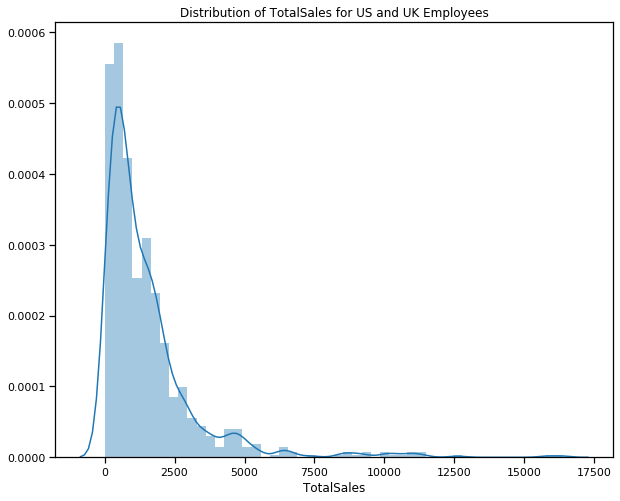

In [43]:
plt.figure(figsize=(10,8))
sns.distplot(df2.TotalSales);
plt.title('Distribution of TotalSales for US and UK Employees')

### Observations:
- The sales are pretty normal with a long right tail.

## Run ANOVA test

In [44]:
#Run ANOVA to see if there is any significance between Country and TotalSales
formula = 'TotalSales ~ C(Country)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq     df         F    PR(>F)
C(Country)  5.393852e+04    1.0  0.015824  0.899927
Residual    2.822429e+09  828.0       NaN       NaN


## Results: The Null Hypothesis is NOT rejected.
The p-value is very high. almost 0.9.

In [45]:
us_employees = df2[df2['Country'] == 'USA']


In [46]:
us_employees.describe()

,EmployeeId,OrderId,TotalSales
count,606.000000,606.000000,606.000000
mean,3.551155,10661.547855,1520.150703
std,2.285388,241.069141,1829.031323
min,1.000000,10250.000000,18.400000
25%,2.000000,10449.250000,456.750000
50%,3.000000,10661.000000,1013.872500
75%,4.000000,10871.000000,1847.660000
max,8.000000,11077.000000,16387.500000


In [47]:
uk_employees = df2[df2['Country'] == 'UK']

In [48]:
uk_employees.describe()

,EmployeeId,OrderId,TotalSales
count,224.000000,224.000000,224.000000
mean,6.709821,10665.075893,1538.311221
std,1.319292,236.639797,1892.265365
min,5.000000,10248.000000,12.500000
25%,6.000000,10482.250000,454.066250
50%,7.000000,10666.500000,868.650000
75%,7.000000,10869.250000,1896.087500
max,9.000000,11074.000000,12615.050000


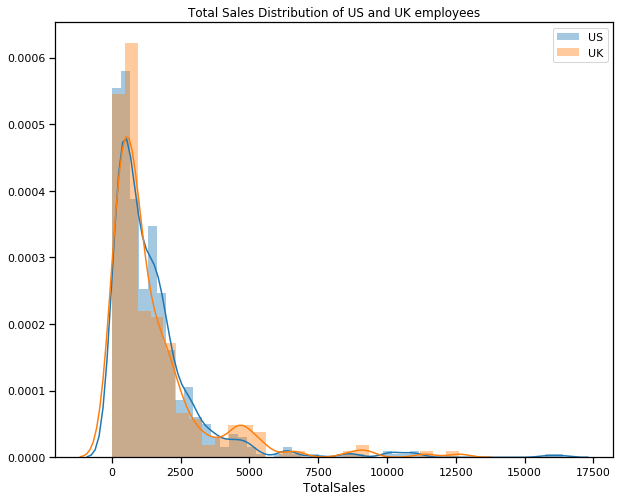

In [49]:
plt.figure(figsize=(10,8))
sns.distplot(us_employees.TotalSales, label='US');
sns.distplot(uk_employees.TotalSales, label='UK');
plt.title('Total Sales Distribution of US and UK employees');
plt.legend();

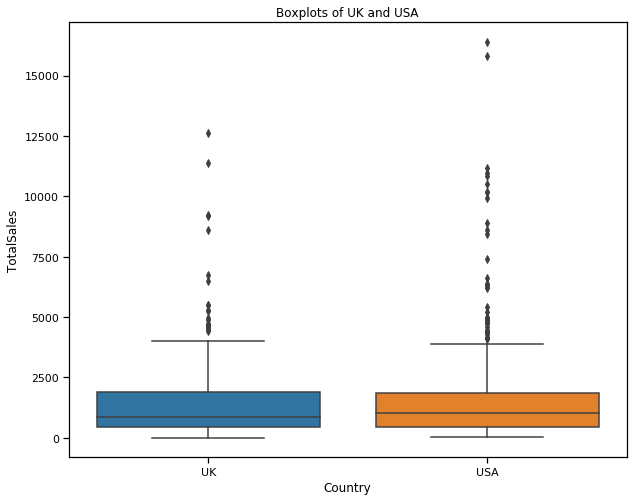

In [50]:
plt.figure(figsize=(10,8))
sns.boxplot(df2.Country, df2.TotalSales);
plt.title('Boxplots of UK and USA');

## Get rid of outliers and run ANOVA test again just to be sure 

In [51]:
df2 = df2.loc[df2.TotalSales <= df2.TotalSales.quantile(.95)]

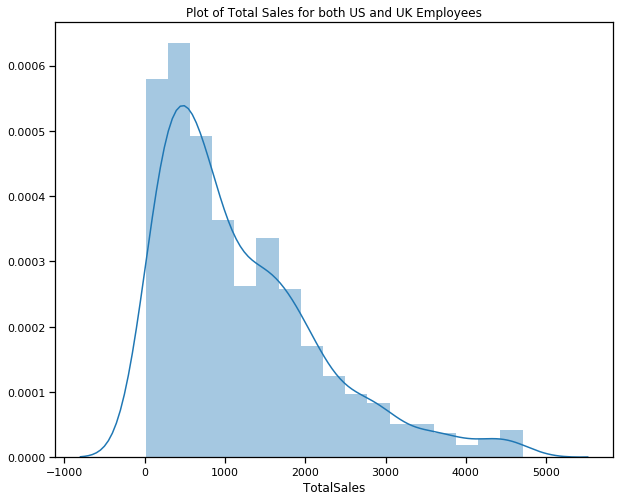

In [52]:
plt.figure(figsize=(10,8))
sns.distplot(df2.TotalSales);
plt.title('Plot of Total Sales for both US and UK Employees');

In [53]:
formula = 'TotalSales ~ C(Country)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq     df         F   PR(>F)
C(Country)  3.665972e+05    1.0  0.365666  0.54555
Residual    7.880006e+08  786.0       NaN      NaN


### Observations:
The Null Hypothesis is still rejected. The p-value is much lower though.

## Plot Each Country Against itself

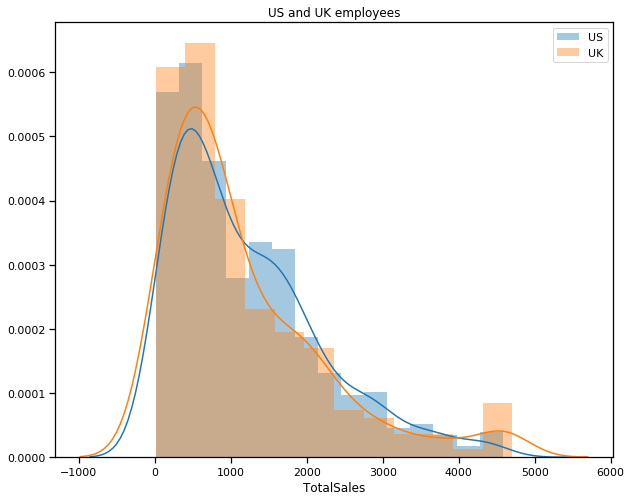

In [54]:
us_employees = df2[df2['Country'] == 'USA']
uk_employees = df2[df2['Country'] == 'UK']
plt.figure(figsize=(10,8))
sns.distplot(us_employees.TotalSales, label='US');
sns.distplot(uk_employees.TotalSales, label='UK');
plt.title('US and UK employees');
plt.legend();

### Observations:
There is still a lot of overlap from the two countries. There is no discernable significant difference.

In [55]:
us_employees.EmployeeId.value_counts()

4    148
3    120
1    118
8    102
2     90
Name: EmployeeId, dtype: int64

In [56]:
uk_employees.EmployeeId.value_counts()

7    66
6    66
5    40
9    38
Name: EmployeeId, dtype: int64

## Business Analysis
Based on the amount sold for each order, the US and the UK sell about the same per order. However, the US has almost three times as many orders as the UK employees do. While the US does have one more employee, they all outsale the top UK employee. Further evaluation of the UK office may need to be made to discover why their sales are so far behind the US employees. Perhaps the UK has certain regulations about where it can sell or it makes sales more difficult than the US employees. More attention should be put into managing the UK team and seeing if they can boost their numbers. 

# Third Question: Does an employee's age have a statistically significant effect on order totals?


## Hypotheses: 
Null: All employees sell the same amounts regardless of age

Alternative: Certain age groups sell more than others

## Explore data

In [57]:
query3 = """SELECT Birthdate, EmployeeId, OrderId, SUM(UnitPrice*Quantity*(1-Discount)) as TotalSales
            FROM Employee
            JOIN [Order]
                ON [Order].EmployeeId = Employee.ID
            JOIN OrderDetail
                ON [Order].Id = OrderDetail.OrderId
            GROUP BY OrderID
            ;"""

In [58]:
df3 = query_to_df(query3)
df3.head()

,BirthDate,EmployeeId,OrderId,TotalSales
0,1987-03-04,5,10248,440.00
1,1995-07-02,6,10249,1863.40
2,1969-09-19,4,10250,1552.60
3,1995-08-30,3,10251,654.06
4,1969-09-19,4,10252,3597.90


In [59]:
df3.BirthDate.value_counts()

1969-09-19    156
1995-08-30    127
1980-12-08    123
1990-01-09    104
1984-02-19     96
1992-05-29     72
1995-07-02     67
1998-01-27     43
1987-03-04     42
Name: BirthDate, dtype: int64

There are only 9 birthdays and quite a few members for each date. I will just use the year and group them together like they already are. 

In [60]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 4 columns):
BirthDate     830 non-null object
EmployeeId    830 non-null int64
OrderId       830 non-null int64
TotalSales    830 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 26.0+ KB


In [61]:
df3['Birth_Year'] = df3['BirthDate'].str[:4]

In [62]:
df3.head()

,BirthDate,EmployeeId,OrderId,TotalSales,Birth_Year
0,1987-03-04,5,10248,440.00,1987
1,1995-07-02,6,10249,1863.40,1995
2,1969-09-19,4,10250,1552.60,1969
3,1995-08-30,3,10251,654.06,1995
4,1969-09-19,4,10252,3597.90,1969


In [63]:
year_dummies = pd.get_dummies(df3.Birth_Year, prefix='Year')

In [64]:
df3 = pd.concat([df3, year_dummies], axis=1)
df3.head()

,BirthDate,EmployeeId,OrderId,TotalSales,Birth_Year,Year_1969,Year_1980,Year_1984,Year_1987,Year_1990,Year_1992,Year_1995,Year_1998
0,1987-03-04,5,10248,440.00,1987,0,0,0,1,0,0,0,0
1,1995-07-02,6,10249,1863.40,1995,0,0,0,0,0,0,1,0
2,1969-09-19,4,10250,1552.60,1969,1,0,0,0,0,0,0,0
3,1995-08-30,3,10251,654.06,1995,0,0,0,0,0,0,1,0
4,1969-09-19,4,10252,3597.90,1969,1,0,0,0,0,0,0,0


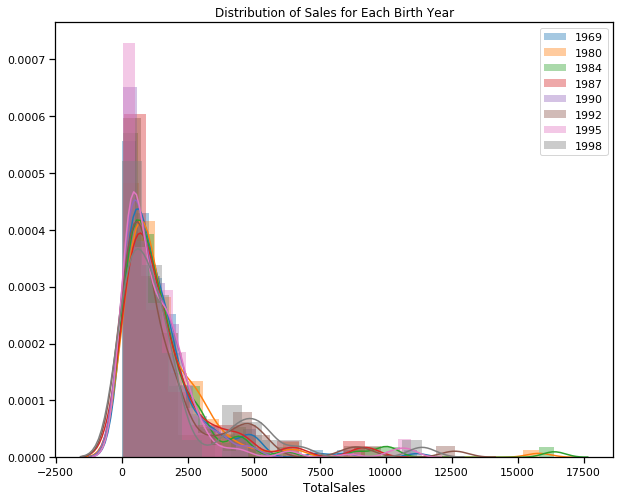

In [65]:
#Plot out each birth year's sales
year_list = ['1969', '1980', '1984', '1987', '1990', '1992', '1995', '1998']
plt.figure(figsize=(10,8))
plt.title('Distribution of Sales for Each Birth Year')
for year in year_list:
    yearX = df3[df3.Birth_Year == year]
    sns.distplot(yearX.TotalSales, label = year);
    
plt.legend();


In [66]:
#Run ANOVA to see if there is any significance between Country and TotalSales
formula = """TotalSales ~ C(Year_1969) + C(Year_1980) + C(Year_1984) + C(Year_1987) +
             C(Year_1990) + C(Year_1992) + C(Year_1995) + C(Year_1998)"""
lm = ols(formula, df3).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq     df         F    PR(>F)
C(Year_1969)  1.379824e+06    1.0  0.405136  0.524626
C(Year_1980)  3.454270e+06    1.0  1.014222  0.314190
C(Year_1984)  1.197958e+07    1.0  3.517373  0.061083
C(Year_1987)  2.859841e+06    1.0  0.839689  0.359754
C(Year_1990)  3.729520e+06    1.0  1.095039  0.295665
C(Year_1992)  9.036989e+06    1.0  2.653386  0.103713
C(Year_1995)  1.310900e+05    1.0  0.038490  0.844511
C(Year_1998)  8.181149e+06    1.0  2.402100  0.121557
Residual      2.799594e+09  822.0       NaN       NaN


## Observations:
No year rejects the Null Hypothesis. All values have a p-value above 0.05.

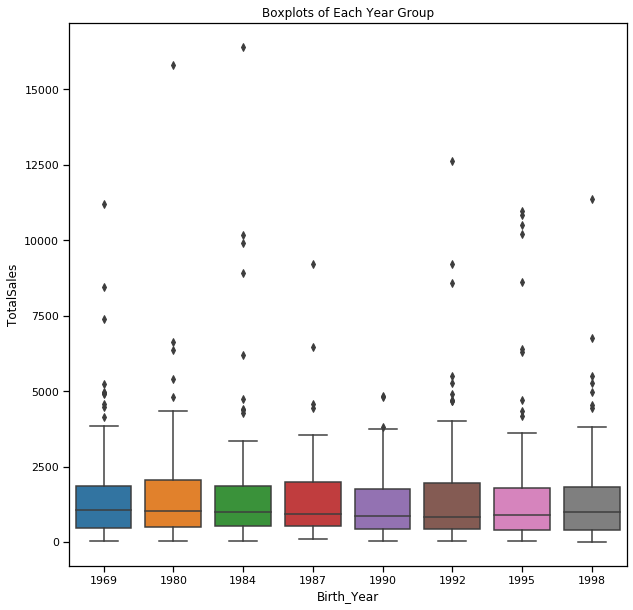

In [67]:
plt.figure(figsize=(10,10))
sns.boxplot(df3.Birth_Year, df3.TotalSales);
plt.title('Boxplots of Each Year Group');

## Remove outliers and run anova again

In [68]:
df3 = df3.loc[df3.TotalSales <= df3.TotalSales.quantile(.95)]

In [69]:
formula = """TotalSales ~ C(Year_1969) + C(Year_1980) + C(Year_1984) + C(Year_1987) +
             C(Year_1990) + C(Year_1992) + C(Year_1995) + C(Year_1998)"""
lm = ols(formula, df3).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq     df         F    PR(>F)
C(Year_1969)  3.302644e+06    1.0  3.282141  0.070422
C(Year_1980)  6.245371e+06    1.0  6.206599  0.012934
C(Year_1984)  2.255936e+06    1.0  2.241931  0.134718
C(Year_1987)  3.076167e+06    1.0  3.057069  0.080780
C(Year_1990)  6.181957e+05    1.0  0.614358  0.433390
C(Year_1992)  1.001216e+06    1.0  0.995000  0.318833
C(Year_1995)  3.623631e+05    1.0  0.360113  0.548618
C(Year_1998)  2.140145e+05    1.0  0.212686  0.644799
Residual      7.848727e+08  780.0       NaN       NaN


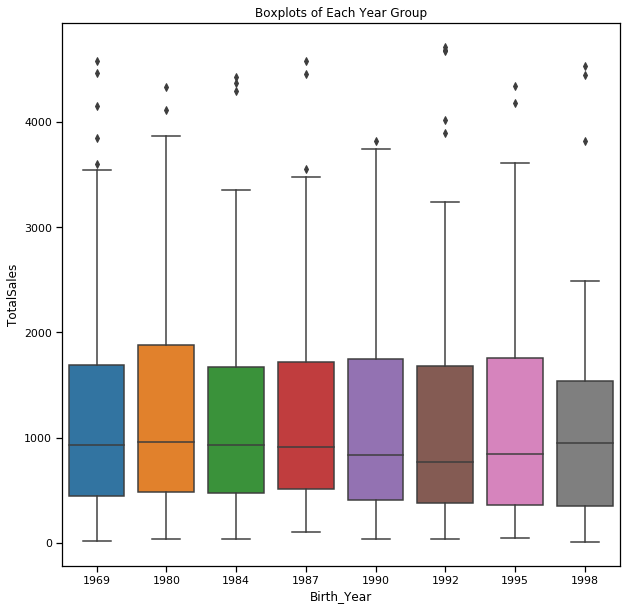

In [70]:
plt.figure(figsize=(10,10))
sns.boxplot(df3.Birth_Year, df3.TotalSales);
plt.title('Boxplots of Each Year Group');

### Observations:
- Just by looking at the boxplots, there is only a small difference from each group
- The means are all very close together. Roughly between 700 and 800

## Business Analysis:
Each age group is capable of making similar sales and it doesn't seem like older or younger employees have any advantage. This may be a testament to the employee training programs. Perhaps they thoroughly go through the sales process and they are able to more comfortably push the companies products. A well thought out and properly planned training program gives employees confidence and can help them avoid getting into difficult situations and losing sales. The training team should be congratulated.

# Fourth Question: Do countries shipped to have a statistically significant effect on discounts?

## Hypotheses: 
Null: All countries use the same discounts

Alternative: Certain countries use more or less discounts

## Explore Data

In [71]:
query4 = """SELECT ShipCountry, OrderId, Discount
           FROM [Order]
           JOIN OrderDetail
                ON [Order].Id = OrderDetail.OrderId
            ;"""

In [72]:
df4 = query_to_df(query4)
df4.head()

,ShipCountry,OrderId,Discount
0,France,10248,0.0
1,France,10248,0.0
2,France,10248,0.0
3,Germany,10249,0.0
4,Germany,10249,0.0


In [73]:
df4.describe()

,OrderId,Discount
count,2155.000000,2155.000000
mean,10659.375870,0.056167
std,241.378032,0.083450
min,10248.000000,0.000000
25%,10451.000000,0.000000
50%,10657.000000,0.000000
75%,10862.500000,0.100000
max,11077.000000,0.250000


In [74]:
df4.ShipCountry.value_counts()

USA            352
Germany        328
Brazil         203
France         184
UK             135
Austria        125
Venezuela      118
Sweden          97
Canada          75
Mexico          72
Belgium         56
Ireland         55
Finland         54
Spain           54
Italy           53
Switzerland     52
Denmark         46
Argentina       34
Portugal        30
Norway          16
Poland          16
Name: ShipCountry, dtype: int64

In [75]:
country_list = df4.ShipCountry.tolist()
country_list = np.unique(np.array(country_list))
print(country_list)

['Argentina' 'Austria' 'Belgium' 'Brazil' 'Canada' 'Denmark' 'Finland'
 'France' 'Germany' 'Ireland' 'Italy' 'Mexico' 'Norway' 'Poland'
 'Portugal' 'Spain' 'Sweden' 'Switzerland' 'UK' 'USA' 'Venezuela']


//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


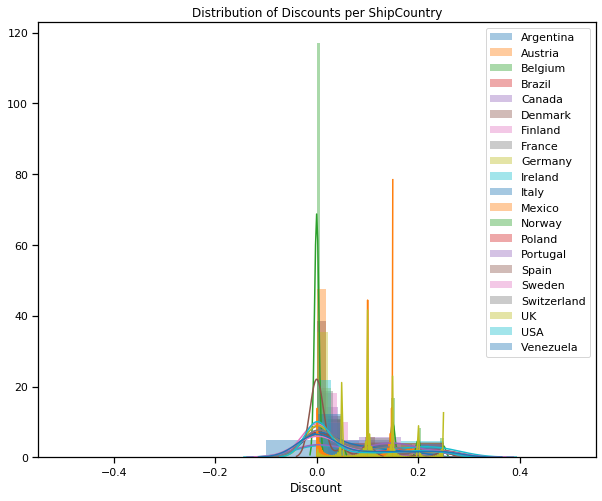

In [76]:
#plot each distribution of Discount for every ShipCountry
plt.figure(figsize=(10,8))
plt.title('Distribution of Discounts per ShipCountry')
for country in country_list:
    country_df = df4[df4['ShipCountry'] == country]
    sns.distplot(country_df.Discount, label=country)
    
plt.legend();

Countries that have less than 50 total orders can be grouped with other countries. The large difference in order sizes can cause issues for further testing especially when it is all the information available.

In [77]:
df4['ShipCountry'] = df4['ShipCountry'].replace({'Norway':'Norway_Poland_Denmark'})
df4['ShipCountry'] = df4['ShipCountry'].replace({'Poland':'Norway_Poland_Denmark'})
df4['ShipCountry'] = df4['ShipCountry'].replace({'Denmark':'Norway_Poland_Denmark'})
df4['ShipCountry'] = df4['ShipCountry'].replace({'Portugal':'Spain_Portugal'})
df4['ShipCountry'] = df4['ShipCountry'].replace({'Spain':'Spain_Portugal'})
df4['ShipCountry'] = df4['ShipCountry'].replace({'Argentina':'Argentina_Venezuela'})
df4['ShipCountry'] = df4['ShipCountry'].replace({'Venezuela':'Argentina_Venezuela'})

In [78]:
df4.ShipCountry.value_counts()

USA                      352
Germany                  328
Brazil                   203
France                   184
Argentina_Venezuela      152
UK                       135
Austria                  125
Sweden                    97
Spain_Portugal            84
Norway_Poland_Denmark     78
Canada                    75
Mexico                    72
Belgium                   56
Ireland                   55
Finland                   54
Italy                     53
Switzerland               52
Name: ShipCountry, dtype: int64

## Run ANOVA to see if there is any significance between Country and TotalSales


In [79]:
formula = 'Discount ~ C(ShipCountry)'
lm = ols(formula, df4).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                   sum_sq      df         F        PR(>F)
C(ShipCountry)   0.609834    16.0  5.662696  3.781260e-12
Residual        14.390506  2138.0       NaN           NaN


### Null Hypothesis is rejected
The p-value is very very small. Much less than 0.05. Further exploration is required

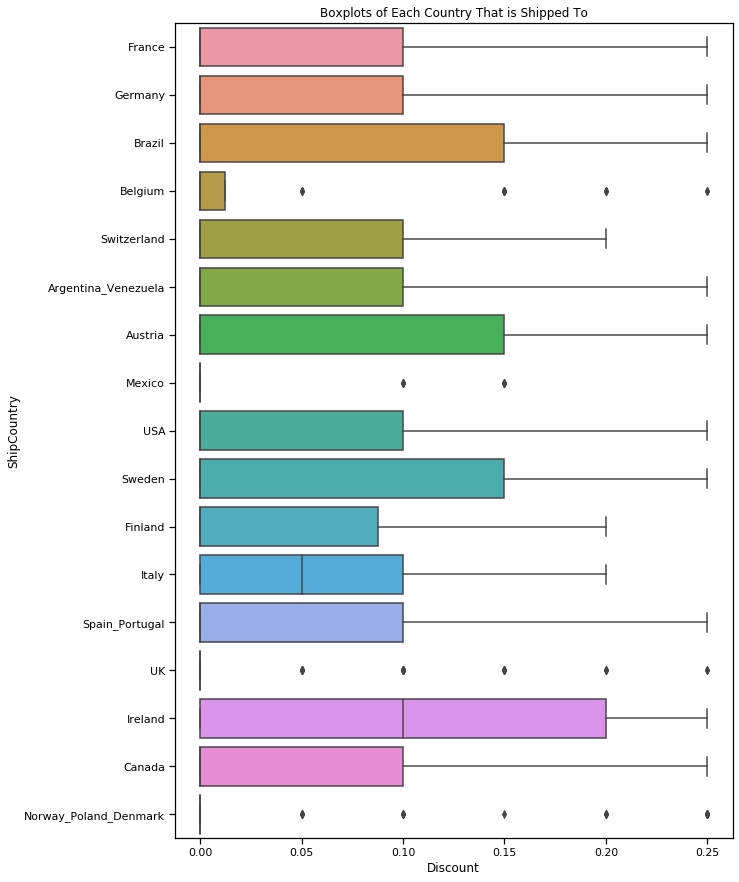

In [96]:
plt.figure(figsize=(10,15))
sns.boxplot(y=df4.ShipCountry, x=df4.Discount, orient="h");
plt.title('Boxplots of Each Country That is Shipped To');

## Further analysis to see if any countries stand out.

In [81]:
country_dummies = pd.get_dummies(df4.ShipCountry, prefix='Co')

In [82]:
df4 = pd.concat([df4, country_dummies], axis=1)
df4.head()

,ShipCountry,OrderId,Discount,Co_Argentina_Venezuela,Co_Austria,Co_Belgium,Co_Brazil,Co_Canada,Co_Finland,Co_France,Co_Germany,Co_Ireland,Co_Italy,Co_Mexico,Co_Norway_Poland_Denmark,Co_Spain_Portugal,Co_Sweden,Co_Switzerland,Co_UK,Co_USA
0,France,10248,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,France,10248,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,France,10248,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Germany,10249,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Germany,10249,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [83]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 20 columns):
ShipCountry                 2155 non-null object
OrderId                     2155 non-null int64
Discount                    2155 non-null float64
Co_Argentina_Venezuela      2155 non-null uint8
Co_Austria                  2155 non-null uint8
Co_Belgium                  2155 non-null uint8
Co_Brazil                   2155 non-null uint8
Co_Canada                   2155 non-null uint8
Co_Finland                  2155 non-null uint8
Co_France                   2155 non-null uint8
Co_Germany                  2155 non-null uint8
Co_Ireland                  2155 non-null uint8
Co_Italy                    2155 non-null uint8
Co_Mexico                   2155 non-null uint8
Co_Norway_Poland_Denmark    2155 non-null uint8
Co_Spain_Portugal           2155 non-null uint8
Co_Sweden                   2155 non-null uint8
Co_Switzerland              2155 non-null uint8
Co_UK                     

In [84]:
formula = """Discount ~ C(Co_Argentina_Venezuela) + C(Co_Austria) + C(Co_Belgium) + C(Co_Brazil) + 
             C(Co_Canada) +  C(Co_Finland) + C(Co_France) + C(Co_Germany) +
             C(Co_Ireland) + C(Co_Italy) + C(Co_Mexico) + C(Co_Norway_Poland_Denmark) + 
             C(Co_Sweden) + C(Co_Switzerland) + 
             C(Co_UK) + C(Co_USA)"""
lm = ols(formula, df4).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                                sum_sq      df          F    PR(>F)
C(Co_Argentina_Venezuela)     0.000421     1.0   0.062488  0.802630
C(Co_Austria)                 0.009901     1.0   1.470927  0.225334
C(Co_Belgium)                 0.009003     1.0   1.337574  0.247592
C(Co_Brazil)                  0.008190     1.0   1.216753  0.270123
C(Co_Canada)                  0.003381     1.0   0.502389  0.478530
C(Co_Finland)                 0.010327     1.0   1.534234  0.215614
C(Co_France)                  0.000009     1.0   0.001379  0.970384
C(Co_Germany)                 0.004660     1.0   0.692368  0.405453
C(Co_Ireland)                 0.115208     1.0  17.116410  0.000037
C(Co_Italy)                   0.000032     1.0   0.004716  0.945257
C(Co_Mexico)                  0.064768     1.0   9.622595  0.001947
C(Co_Norway_Poland_Denmark)   0.009122     1.0   1.355292  0.244485
C(Co_Sweden)                  0.011319     1.0   1.681617  0.194850
C(Co_Switzerland)             0.001052     1.0  

### Observations:
- Certain countries seem to be using different discounts than others. Specifically Ireland. Others of interest are  Mexico, and the UK

- Graphs may make this more easily readable

In [85]:
avg_disc_df = query_to_df("""SELECT ShipCountry, OrderId, AVG(Discount) as Discount_Avg
                             FROM [Order]
                             JOIN OrderDetail
                                 ON [Order].Id = OrderDetail.OrderId
                             GROUP BY ShipCountry
            ;""")
avg_disc_df.head()

,ShipCountry,OrderId,Discount_Avg
0,Argentina,10409,0.000000
1,Austria,10258,0.068800
2,Belgium,10252,0.038393
3,Brazil,10250,0.066502
4,Canada,10332,0.064000


Text(0.5, 1.0, 'Average Discount for Each Country')

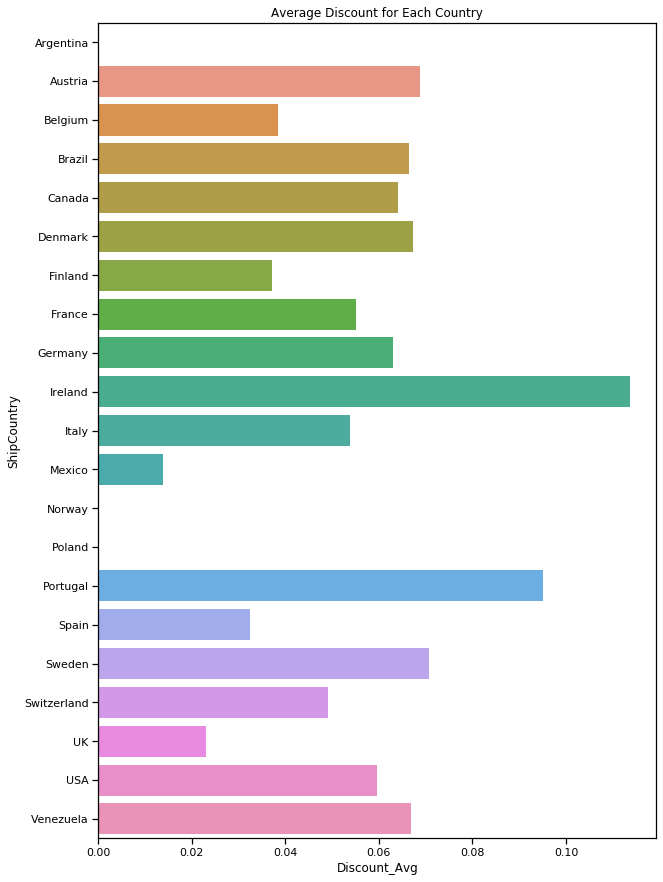

In [98]:
plt.figure(figsize=(10,15))
sns.barplot(y=avg_disc_df.ShipCountry, x=avg_disc_df.Discount_Avg, orient="h")
plt.title('Average Discount for Each Country')

### Observations:
- Irealand has a significantly higher disoucnt average over all their orders than any country
- Norway and Poland recieve no discount
- Even though the UK and Mexico had a large p-value, they have some of the lowest average discounts

## Business Analysis:
Ireland and Portugal have the highest discount averages per orders. Further exploration should be continued to see if a higer or lower profit is being made in countries where there seems to be a higher amount of discounts per order or if they are recieving them unnecessarily. On the other end, the countries with the lower discount averages should be investigated as well. With enough information you can then compare countries with similar order amounts and see how much of an effect the discounts had on profits.